# Immersed layer caches

This package uses precomputed caches to efficiently implement the immersed layer
operators. The starting point for a cache is the specification of the
(discretized) body shape and the grid. Let's use an example.

## Setting up a cache

In [1]:
using ImmersedLayers
using Plots
using LinearAlgebra

### Set up a grid
First, we will set up a grid for performing the operations. We use the `PhysicalGrid`
constructor of the `CartesianGrids.jl` package to create this.

In [2]:
Δx = 0.01
Lx = 4.0
xlim = (-Lx/2,Lx/2)
ylim = (-Lx/2,Lx/2)
g = PhysicalGrid(xlim,ylim,Δx)

PhysicalGrid{2}((408, 406), (204, 203), 0.01, ((-2.0300000000000002, 2.0300000000000002), (-2.02, 2.02)), 10)

### Set the shape
Now let's set a shape to immerse into the grid. We will use a circle, but
there are a variety of other shapes available. Many of these are in the
`RigidBodyTools.jl` package. Note that we set the spacing between the points
on this shape equal to 1.4 times the grid spacing. This is not critical, but it
is generally best to set it to a value between 1 and 2.

In [3]:
RadC = 1.0
Δs = 1.4*cellsize(g)
body = Circle(RadC,Δs)

Circular body with 448 points and radius 1.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


### Create the cache
After setting the grid and the surface to immerse, the next step for using the
immersed layer tools is to set up a *surface cache*. This allocates a set of
data structures, as well as the critical *regularization* and *interpolation*
operators that will get used.

There are a few choices to make when setting this up
* **What kind of data (scalar or vector) are we dealing with?**

We will demonstrate with scalar data, which means we use the `SurfaceScalarCache`
function. For vector data, use `SurfaceVectorCache`.

* **What type of scaling (grid or index) do we wish to apply to the operators?**

Grid scaling, set with `scaling = GridScaling`, means that the various operators are scaled with the physical grid spacing
and/or surface point spacing so that they approximate the continuous operators. This
means that regularization and interpolation are transposes with respect to
inner products that incorporate these physical spacings, rather than the usual
linear algebra inner products. Also, differential operations on the grid are true
approximations of their continuous counterparts. This choice of scaling is usually the best, and
the `dot` operator is extended in this package to implement the physically-
scaled inner products.

On the other hand, `scaling = IndexScaling` does not scale these, but rather, uses
pure differencing for the grid differential operators, and regularization is
the simple matrix transpose of interpolation.

* **What discrete Dirac delta function (DDF) do we wish to use?**

This is specified with the `ddftype` keyword argument. The default is
`ddftype=CartesianGrids.Yang3` [^1]. However, there are
other choices, such as `CartesianGrids.Roma`, `CartesianGrids.Goza`, `CartesianGrids.Witchhat`,
`CartesianGrids.M3`, `CartesianGrids.M4prime`.

In [4]:
cache = SurfaceScalarCache(body,g,scaling=GridScaling)

Surface cache with scaling of type GridScaling
  448 point data of type ScalarData{448, Float64, Vector{Float64}}
  Grid data of type Nodes{Primal, 408, 406, Float64, Matrix{Float64}}


## Plotting the immersed points
We can plot the immersed points with the `plot` function of the `Plots.jl`
package, using a special plot recipe. This accepts all of the
usual attribute keywords of the basic plot function.

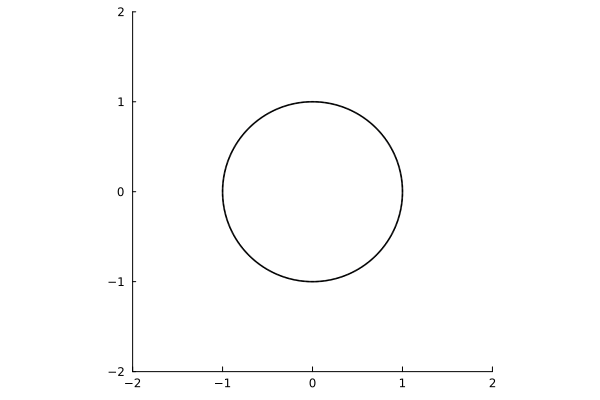

In [5]:
plot(cache,xlims=(-2,2),ylims=(-2,2))

In this plotting demonstration, we have used the `points` function
to obtain the coordinates of the immersed points. Other useful
utilities are `normals`, `areas`, and `arcs`, e.g.

In [6]:
normals(cache)

448 points of vector-valued Float64 data
896-element Vector{Float64}:
  0.9999999999988712
  0.9999016728287639
  0.9996065842578712
  0.999115045044428
  0.9984267309011199
  0.9975423661130551
  0.9964613682740765
  0.9951848732366676
  0.9937120427187925
  0.992044421068211
  ⋮
 -0.12589126758565716
 -0.11196299239880425
 -0.09801862843388753
 -0.08404903300348561
 -0.07006887224977693
 -0.05606894942065292
 -0.04206398840993138
 -0.02804475491729984
 -0.014026009668317694

## Some basic utilities
We will see deeper uses of this cache in Surface-grid operations.
However, for now we can learn how to get basic copies of the grid
and surface data. For example, a copy of the grid data, all initialized to zero:

In [7]:
zeros_grid(cache)

Nodes{Primal, 408, 406, Float64, Matrix{Float64}} data
Printing in grid orientation (lower left is (1,1))
405×407 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱  ⋮                        ⋮    
 0.0  0.0  0.0

or similarly on the surface

In [8]:
zeros_surface(cache)

448 points of scalar-valued Float64 data
448-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

We also might need to initialize data on the grid to accept the curl of
a vector field. This is used in conjunction with `surface_curl!`,
for example.

In [9]:
zeros_gridcurl(cache)

Nodes{Dual, 408, 406, Float64, Matrix{Float64}} data
Printing in grid orientation (lower left is (1,1))
406×408 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱                      ⋮         
 0.0  0.0  0.0  

If we want them initialized to unity, then use

In [10]:
ones_grid(cache)

Nodes{Primal, 408, 406, Float64, Matrix{Float64}} data
Printing in grid orientation (lower left is (1,1))
405×407 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 ⋮                        ⋮              ⋱  ⋮                        ⋮    
 1.0  1.0  1.0

and

In [11]:
ones_surface(cache)

448 points of scalar-valued Float64 data
448-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

To evaluate functions on the grid, it is useful to be able to
fill grid data with the x and y coordinates. For this, we use

In [12]:
x_grid(cache)

Nodes{Primal, 408, 406, Float64, Matrix{Float64}} data
Printing in grid orientation (lower left is (1,1))
405×407 Matrix{Float64}:
 -2.03  -2.02  -2.01  -2.0  -1.99  …  1.98  1.99  2.0  2.01  2.02  2.03
 -2.03  -2.02  -2.01  -2.0  -1.99     1.98  1.99  2.0  2.01  2.02  2.03
 -2.03  -2.02  -2.01  -2.0  -1.99     1.98  1.99  2.0  2.01  2.02  2.03
 -2.03  -2.02  -2.01  -2.0  -1.99     1.98  1.99  2.0  2.01  2.02  2.03
 -2.03  -2.02  -2.01  -2.0  -1.99     1.98  1.99  2.0  2.01  2.02  2.03
 -2.03  -2.02  -2.01  -2.0  -1.99  …  1.98  1.99  2.0  2.01  2.02  2.03
 -2.03  -2.02  -2.01  -2.0  -1.99     1.98  1.99  2.0  2.01  2.02  2.03
 -2.03  -2.02  -2.01  -2.0  -1.99     1.98  1.99  2.0  2.01  2.02  2.03
 -2.03  -2.02  -2.01  -2.0  -1.99     1.98  1.99  2.0  2.01  2.02  2.03
 -2.03  -2.02  -2.01  -2.0  -1.99     1.98  1.99  2.0  2.01  2.02  2.03
  ⋮                                ⋱                         ⋮     
 -2.03  -2.02  -2.01  -2.0  -1.99     1.98  1.99  2.0  2.01  2.02  2.03
 -2.03  -

In [13]:
y_grid(cache)

Nodes{Primal, 408, 406, Float64, Matrix{Float64}} data
Printing in grid orientation (lower left is (1,1))
405×407 Matrix{Float64}:
  2.02   2.02   2.02   2.02   2.02  …   2.02   2.02   2.02   2.02   2.02
  2.01   2.01   2.01   2.01   2.01      2.01   2.01   2.01   2.01   2.01
  2.0    2.0    2.0    2.0    2.0       2.0    2.0    2.0    2.0    2.0
  1.99   1.99   1.99   1.99   1.99      1.99   1.99   1.99   1.99   1.99
  1.98   1.98   1.98   1.98   1.98      1.98   1.98   1.98   1.98   1.98
  1.97   1.97   1.97   1.97   1.97  …   1.97   1.97   1.97   1.97   1.97
  1.96   1.96   1.96   1.96   1.96      1.96   1.96   1.96   1.96   1.96
  1.95   1.95   1.95   1.95   1.95      1.95   1.95   1.95   1.95   1.95
  1.94   1.94   1.94   1.94   1.94      1.94   1.94   1.94   1.94   1.94
  1.93   1.93   1.93   1.93   1.93      1.93   1.93   1.93   1.93   1.93
  ⋮                                 ⋱                        ⋮     
 -1.94  -1.94  -1.94  -1.94  -1.94     -1.94  -1.94  -1.94  -1.94  -1.94

## Using norms and inner products
It is useful to compute norms and inner products on grid and surface data.
These tools are easily accessible, e.g., `dot(u,v,cache)` and `norm(u,cache)`,
and they respect the scaling associated with the cache. For example,
the following gives an approximation of the circumference of the circle:

In [14]:
os = ones_surface(cache)
dot(os,os,cache)

6.283288300933757

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*